# Attempt 1

In [1]:
import tensorflow as tf
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

from flows import *

import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
def plot_density(data):
    x, y = np.squeeze(np.split(data, 2, axis=1))
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)

    xmin, xmax = min(x), max(x)
    ymin, ymax = min(y), max(y)

    # Peform the kernel density estimate
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    f = np.reshape(kernel(positions).T, xx.shape)
    
    # Plot the kernel density estimate
    plt.contourf(xx, yy, f, cmap='viridis')
    plt.gca().set_aspect('equal')

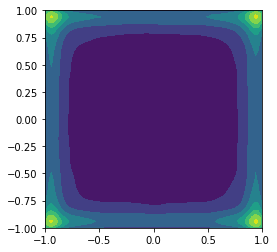

In [4]:
N = 1000000
data = np.sin(stats.multivariate_normal.rvs([0, 0], [1, 1], size = N))
plot_density(data)

In [7]:
target = flow(data)

2022-12-08 02:21:41.895972: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 02:21:42.449250: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21271 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:41:00.0, compute capability: 7.5
  0%|          | 0/40 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


100%|██████████| 40/40 [8:20:50<00:00, 751.27s/it]  


In [8]:
target_data = target.sample(N)

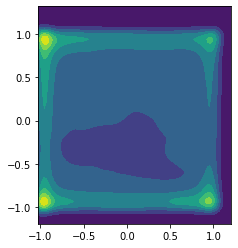

In [9]:
plot_density(target_data)

In [10]:
# Get probabilities
target.prob(target_data).numpy()

array([0.16003376, 2.4778721 , 1.1893747 , ..., 0.18056087, 0.16585764,
       0.4400025 ], dtype=float32)